# Baesyan Data Analysis Course - Chapter 4 Exercises
https://github.com/avehtari/BDA_course_Aalto/tree/master/exercises

### Exercise 1 - Bioassay Model

In this exercise, you will use a dose-response relation model that is used in Section 3.7 of the course book and in the chapter reading instructions [here](https://github.com/avehtari/BDA_course_Aalto/blob/master/chapter_notes/BDA_notes_ch3.pdf). The used likelihood is the same, but instead of uniform priors, we will use a bivariate normal distribution as the joint prior distribution of the parameters $\alpha$ and $\beta$.

**a)** In the prior distribution for $(\alpha,\beta)$, the marginal distributions are $\alpha \sim N(0,2^2)$ and $\beta \sim N(10,10^2)$, and the correlation between them is $\mathrm{corr}(\alpha, \beta)=0.5$. Report the full mean and covariance of the bivariate normal distribution.

**Answer:** The correlation relates to the covariance trough the equation $\mathrm{corr}(\alpha, \beta) = \dfrac{\mathrm{cov}(\alpha, \beta)}{\sigma_\alpha\sigma_\beta}$, where $\sigma_\alpha$ and $\sigma_\beta$ are the std. deviations of $\alpha$ and $\beta$, respectively. This implies that:

In [44]:
cor_αβ = 0.5
σα = 2
σβ = 10
cov_αβ = cor_αβ*σα*σβ
print("cov(α, β) = %.2f"  %cov_αβ)
Σ = np.array([[σα**2, cov_αβ],
            [cov_αβ, σβ**2]])
μ = [0, 10]

cov(α, β) = 10.00


Thus, $\alpha, \beta \sim N(\mathbf{\mu}, \Sigma)$, where
$$
\mathbf{\mu} = \left[\begin{array}{cc} 
0 \\10 
\end{array}\right] , \quad
\Sigma = \left[\begin{array}{cc} 
2^2 & 10\\
10 & 10^2
\end{array}\right]
$$

**b)** You are given 4000 independent draws from the posterior distribution
of the model. Load the draws with from *bioassay\_posterior*. Report the mean as well as 5 $\%$ and 95 $\%$
quantiles separately for both $\alpha$ and $\beta$. Report also the
Monte Carlo standard errors (MCSEs) for the mean and quantile estimates.
Report as many digits for the mean and
quantiles as the MCSEs allow. In other words, leave out digits where
MCSE is nonzero (Example: if posterior mean is 2.345678 and MCSE is 0.0012345, report two digits after the decimal sign, taking into account the usual rounding rule, so you would report 2.35. Further digits do not contain useful information due to the Monte Carlo uncertainty.).


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

posterior_draws = pd.read_csv('Data//bioassay_posterior.txt', sep="\t", header=None)
posterior_draws.columns = ["α", "β"]

In [123]:
posterior_summaries = pd.DataFrame(index = ["q95", "mean", "q05"], columns = posterior_draws.columns)
for col in posterior_draws.columns:
    q95 = np.quantile(a = posterior_draws[col], q = 0.95)
    q05 = np.quantile(a = posterior_draws[col], q = 0.05)
    mean = np.mean(posterior_draws[col])
    posterior_summaries[col] = [q975, mean, q025]

posterior_summaries

,α,β
q95,21.223498,21.223498
mean,0.985226,10.596481
q05,3.338925,3.338925


In [124]:
MCSE_summaries = pd.DataFrame(index = ["q95", "mean", "q05"], columns = posterior_draws.columns)
def MCSE(draws, prob):
    S = len(draws)
    p = [0.1586553, 0.8413447, 0.05, 0.95]
    a = beta.ppf(p, S * prob + 1, S * (1 - prob) + 1)
    sdraws = np.sort(draws)
    th1 = sdraws[int(max(np.round(a[0]*S), 1))]
    th2 = sdraws[int(min(np.round(a[1]*S), S))]
    return (th2 - th1) / 2
for col in posterior_draws.columns:
    MCSE_summaries[col] = [MCSE(posterior_draws[col], 0.95), np.sqrt(np.var(posterior_draws[col])/len(posterior_draws[col])),
                           MCSE(posterior_draws[col], 0.05)]
MCSE_summaries

,α,β
q95,0.042242,0.238241
mean,0.014822,0.075591
q05,0.026073,0.071125


The results are summarized in the following table:

|   a  | q95 | mean | q05 |
|  ---  | --- | --- | --- |
|$\alpha$| 21.2 | 1.0 | 3.3 |
|MCSE| (0.042242) | (0.014822) | (0.026073) |
|$\beta$| 21 | 10.6 | 3.3 |
|   MCSE  | (0.238241)| (0.075591) | (0.071125) |


## Importance sampling
Now we discard our posterior draws and switch to importance sampling.

**c)** Implement a function for computing the log importance ratios (log importance weights) when the importance sampling **target distribution** is the posterior distribution, and the **proposal distribution** is the prior distribution from **a)**.

**Answer:** First, load and look at the data.

In [30]:
dat = pd.read_csv('Data//bioassay.txt', sep=" ")
dat

,x,n,y
0,-0.86,5,0
1,-0.30,5,1
2,-0.05,5,3
3,0.73,5,5


The importance ratio is given by

$$w(\alpha^s, \beta^s) = \dfrac{q(\alpha^s, \beta^s|y)}{g(\alpha^s, \beta^s)}$$

where $g(.)$ is the proposal distribution, and $q(.)$ is the target distribution. Denoting $p(\alpha, \beta)$ as the joint prior, it follows that $g(\alpha, \beta)$ = $p(\alpha, \beta)$. And since $q(.)$ is proportional to the posterior distribution, it follows that $q(\alpha, \beta|y) = p(\alpha, \beta)p(y|\alpha, \beta) = g(\alpha, \beta)p(y|\alpha, \beta)$. Thus, the importance ratio reduces to the likelihood:

$$w(\alpha^s, \beta^s) = \dfrac{q(\alpha^s, \beta^s|y)}{g(\alpha^s, \beta^s)} =  \dfrac{g(\alpha, \beta)p(y|\alpha, \beta)}{g(\alpha^s, \beta^s)} =  p(y|\alpha, \beta)$$

In [225]:
from scipy.stats import multivariate_normal as mvn
from scipy.special import binom

def sigmoid(x):
    return 1/(1+np.exp(-1*np.array(x)))

def bio_log_likelihood(α, β):
    z = sigmoid(α + β*dat['x'])
    eps = 1e-12
    z = np.array([min(z[i], 1 - eps) for i in range(len(z))])
    z = np.array([max(z[i], eps) for i in range(len(z))])
    return dat['y']@np.log(z) + (dat['n']-dat['y'])@np.log((1-z))

def prior(α, β):
    return mvn.pdf([α, β],mean=μ, cov=Σ)
    
def log_importance_weights(α, β):
    if type(α) == int or type(α) == float:
        α = [α]
        β = [β]
    return [np.log(prior(α[i], β[i]))*bio_log_likelihood(α[i], β[i])/np.log(mvn.pdf([α[i], β[i]],mean=μ, cov=Σ)) 
            for i in range(len(α))]

In [226]:
alpha_test = [1.896, -3.6, 0.374, 0.964, -3.123, -1.581]
beta_test = [24.76, 20.04, 6.15, 18.65, 8.16, 17.4]

In [227]:
# results for test matching the solution given in the exercise
np.round(log_importance_weights(alpha_test, beta_test), 2)

array([ -8.95, -23.47,  -6.02,  -8.13, -16.61, -14.57])

**d)** Implement a function for computing normalized importance ratios
from the unnormalized log ratios in **c)**. In other words, exponentiate
the log ratios and scale them such that they sum to one.

In [228]:
def nomalized_importance_weights(α, β):
    unmormalized = np.exp(log_importance_weights(α, β))
    return unmormalized / sum(unmormalized)

In [229]:
# results for test matching the solution given in the exercise
np.round(nomalized_importance_weights(alpha_test, beta_test), 3)

array([0.045, 0.   , 0.852, 0.103, 0.   , 0.   ])

**e)**  Sample 4000 draws of $\alpha$ and $\beta$ from the prior distribution from a). Compute and plot a histogram of the 4000 normalized importance ratios. Use the functions you implemented in c) and d).

In [273]:
prior_samples = mvn.rvs(mean = μ, cov = Σ, size = 4000)
α_sim, β_sim = prior_samples[:, 0], prior_samples[:, 1]
importance_ratios = nomalized_importance_weights(α_sim, β_sim)
unormalized = np.exp(log_importance_weights(α_sim, β_sim))

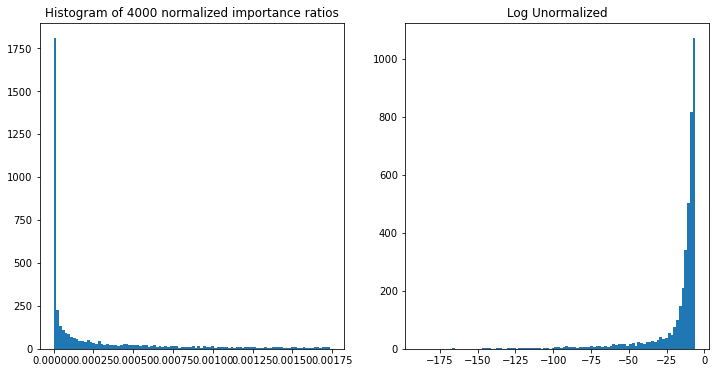

In [277]:
fig, axes = plt.subplots(ncols = 2, figsize = (12,6))
axes[0].hist(importance_ratios, bins = 100)
axes[0].set_title("Histogram of 4000 normalized importance ratios")
axes[1].hist(np.log(unormalized), bins = 100)
axes[1].set_title("Log Unormalized")
plt.show()

**f)** Using the importance ratios, compute the importance sampling effective sample size $S_{\text{eff}}$ and report it.

**Answer:** The effective sample size can be approximated by

$$S_{\text{eff}} = \dfrac{1}{\sum_{s=1}^S (\tilde{w}(\theta^s))^2}$$

where $\tilde{w}(\theta^s)$ are the normalized weights.

In [268]:
def S_eff(α_sim, β_sim):
    return 1/sum((nomalized_importance_weights(α_sim, β_sim))**2)

In [313]:
S_eff_sim = S_eff(α_sim, β_sim)
print("The importance sampling effect sample size is %.2f" %S_eff_sim)

The importance sampling effect sample size is 1078.33


**g)** Explain in your own words what the importance sampling effective
 sample size represents. Also explain how the effective sample size is seen
 in the histogram of the weights that you plotted in e).
 
 **Answer:** It relates to the actual number of samples, $S$, taken from the proposal distribution. The better is the approximation of this proposal distribution to the target, the higher will be the effective sample size (up to $S$). The histogram helps to visualize possible problems in the importance sampling, more specifically, it is desirable that there are a lot of samples with high importance, and few with low importance, which would indicate a good match between proposal and target. In the present case, the histogram shows that there is a high probability of fiding low importance ratios, and this probability gets lower as the importance gets higher. For this reason, the effect sample size is rought $1/4$ of $S$.

**h)** Implement a function for computing the posterior mean using importance sampling, and compute the mean using your 4000 draws.
 Report the means for alpha and beta, and also the Monte Carlo standard errors (MCSEs) for the mean estimates.
 Report the number of digits for the means based on the MCSEs.
 
 **Answer:** We want to compute the posterior mean of $\alpha, \beta|y$. define $\theta = (\alpha, \beta)$. From equations (10.2) and (10.3) of BDA page 265, it follows that an estimate for the posterior mean is
 
 $$\tilde{E}[\theta^s | y] = \dfrac{\frac{1}{S}\sum_{s=1}^S \theta^s \times w(\theta^s)}{\frac{1}{S}\sum_{s=1}^Sw(\theta^s)}$$
 
where $\theta^s$ are draws from the proposal distribution, $S$ is the total number of samples, and $w(\theta^s$ is the importance ratio. Using the normalized importance ratio, $\tilde{w}(\theta^s)$, it follows that 

 $$\tilde{E}[\theta^s | y] = \sum_{s=1}^S [\tilde{w}(\theta^s) \times \theta^s]$$

In [304]:
def posterior_mean(α, β):
    a = nomalized_importance_weights(α, β)@np.array(α)
    b = nomalized_importance_weights(α, β)@np.array(β)
    return np.array([a, b])

In [340]:
post_mean = posterior_mean(α_sim, β_sim)
print("posterior mean using importance sample:", post_mean)

posterior mean using importance sample: [ 0.97099794 10.3353413 ]


To calculate the MCSE, the effective sample size is used. Using $Var(\theta) = E(\theta^2) - E(\theta)^2$, it follows that:

$$MCSE_{E[\theta]} = \sqrt{\dfrac{Var(\theta)}{S_{\text{eff}}}}$$

In [341]:
post_sqr_mean = [nomalized_importance_weights(α_sim, β_sim)@np.array(α_sim**2), 
                nomalized_importance_weights(α_sim, β_sim)@np.array(β_sim**2)]
MCSE_E = np.sqrt( (post_sqr_mean - post_mean**2) / S_eff_sim)
print("The MCSE for the posterior mean is", MCSE_E)

The MCSE for the posterior mean is [0.02757961 0.14064245]


The results are summarized in the following table:

|       | $\alpha$  | $\beta$ |
|  ---  | ---       | ---     |
|  mean | 1.0       | 10      |
| MCSE  |0.02757961 |0.14064245| 
